# **Load model**

In [1]:
import sys
sys.path.insert(0, '../')

import molecule_vae

grammar_weights = "../weights/GrammarVAE_L128.hdf5"
grammar_model = molecule_vae.GrammarModel(grammar_weights, latent_rep_size=128)

two_tower_grammar_weights = "../weights/Two_tower_GrammarVAE_L128.hdf5"
two_tower_grammar_model = molecule_vae.GrammarModel(two_tower_grammar_weights, latent_rep_size=128, two_tower=True)

character_weights = "../weights/CharVAE_L128.hdf5"
character_model = molecule_vae.CharacterModel(character_weights, latent_rep_size=128)

two_tower_character_weights = "../weights/Two_tower_CharVAE_L128.hdf5"
two_tower_character_model = molecule_vae.CharacterModel(two_tower_character_weights, latent_rep_size=128, two_tower=True)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1e-04
1e-04
1e-04
1e-04


# **Load property data**

In [2]:
import pandas as pd

data_path="../datasets/delaney.csv"

df=pd.read_csv(data_path)
df=df.loc[~df['smiles'].str.contains('.', regex=False)]
targets=df.iloc[:, 1:].values
smiles=df["smiles"].values

print(smiles.shape, targets.shape)
df

(1128,) (1128, 1)


,smiles,logSolubility
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,CC(C)=CCCC(C)=CC(=O),-2.060
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,c1ccsc1,-1.330
...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,CCSCCSP(=S)(OC)OC,-3.091
1126,CCC(C)C,-3.180


# **Encoding datasets**

In [3]:
import numpy as np
from tqdm import tqdm
from descriptastorus.descriptors import rdNormalizedDescriptors
from rdkit.Chem import MolToSmiles, MolFromSmiles, SanitizeMol

generator = rdNormalizedDescriptors.RDKit2DNormalized()

def clean_smiles(smi):
    mol = MolFromSmiles(smi)
    SanitizeMol(mol)
    return MolToSmiles(mol, isomericSmiles=True)

def rdkit_2d_normalized_features(smiles: str):
    results = generator.process(smiles)
    processed, features = results[0], results[1:]
    if processed is None:
       print("Unable to process smiles %s", smiles)
    return features

def rdkit_features(smiles_list):
    features=[]
    for compound in smiles_list:
        features.append(rdkit_2d_normalized_features(compound))
    features=np.expand_dims(features, axis=2)
    return features

def encode_smiles(model, smiles, targets):
    smiles_list=[]
    latent_rep_list = []
    targets_list=[]
    for smi, target in tqdm(zip(smiles, targets), total=len(smiles)):
        try:
            smi = [clean_smiles(smi)]
            if model._two_tower:
                features = rdkit_features(smi)
            else:
                features=None
            z = model.encode(smi, np.array(features))
            latent_rep_list.append(z.flatten())
            smiles_list.extend(smi)
            targets_list.append(target)
        except:
            # print('Failed to encode smiles')
            continue

    return smiles_list, np.array(targets_list), np.array(latent_rep_list)

In [4]:
# Grammar model
two_tower_grammar_smiles, two_tower_grammar_targets, two_tower_grammar_latent_rep = encode_smiles(two_tower_grammar_model, smiles, targets)
grammar_smiles, grammar_targets, grammar_latent_rep = encode_smiles(grammar_model, smiles, targets)


# # Character model
two_tower_char_smiles_list, two_tower_char_targets, two_tower_char_latent_rep = encode_smiles(two_tower_character_model, smiles, targets)
char_smiles, char_targets, char_latent_rep = encode_smiles(character_model, smiles, targets)

  0%|          | 0/1128 [00:00<?, ?it/s]


100%|██████████| 1128/1128 [00:02<00:00, 493.20it/s]


# **Predictive model**

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def create_model(hidden_size=1024, classification=True, input_size=56, output_size=1, activation='sigmoid', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()]):
    model = Sequential()
    model.add(Input(shape=(input_size)))
    model.add(Dense(units=hidden_size, activation='relu', ))    
    model.add(Dropout(0.5))        
    model.add(Dense(units=output_size, activation=activation))

    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    mode='min'
)

# **Regression**

Run the following cells if the prediction task is a regression

In [10]:
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

def rmse(y_pred, y_true):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def get_regression_loss(X,y,latent_rep_size, loss_metric, folds=10):
    kfold = KFold(n_splits=folds, shuffle=True, random_state=0)
    losses = []
    for train, test in tqdm(kfold.split(X, y), total=folds):
        model=create_model(input_size=latent_rep_size, activation="linear", loss=loss_metric)

        model.fit(X[train], y[train], epochs=250, batch_size=256, validation_split=0.1, verbose=0, callbacks = [early_stop])
        loss=model.evaluate(X[test], y[test], verbose=0)
        losses.append(loss)
    print(np.average(losses), np.std(losses))
    

In [11]:
get_regression_loss(two_tower_grammar_latent_rep, grammar_targets, latent_rep_size=128, loss_metric=rmse)
get_regression_loss(grammar_latent_rep, grammar_targets, latent_rep_size=128, loss_metric=rmse)

get_regression_loss(two_tower_char_latent_rep, char_targets, latent_rep_size=128, loss_metric="mae")
get_regression_loss(char_latent_rep, char_targets, latent_rep_size=128, loss_metric="mae")

  0%|          | 0/10 [00:00<?, ?it/s]

0.2090290228749896 0.2944431784216386


  0%|          | 0/10 [00:00<?, ?it/s]

0.4471593568763224 0.6330445093333232


  0%|          | 0/10 [00:00<?, ?it/s]

0.17050341663138804 0.2423653800240772


100%|██████████| 10/10 [02:25<00:00, 14.57s/it]

0.35559393945426765 0.5025854291622176


# **Binary Classification**

Run the following cells if the prediction task is a binary classification

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

def get_average_ROC_curve(X, y, latent_rep_size, folds=10): 
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)

    interp_tprs = []
    tprs = []
    fprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)    
    for train, test in tqdm(kfold.split(X, y), total=folds):
        model=create_model(input_size=latent_rep_size)

        model.fit(X[train], y[train], epochs=250, batch_size=256, validation_split=0.1,  verbose=0, callbacks = [early_stop])

        preds=model.predict(X[test], batch_size=256)
        fpr, tpr, _ = roc_curve(y[test], preds)
        tprs.append(tpr)
        fprs.append(fpr)

        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        interp_tprs.append(tpr)

    interp_tprs = np.array(interp_tprs)
    mean_tprs = interp_tprs.mean(axis=0)
    std = interp_tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    return fprs, tprs, base_fpr, mean_tprs, mean_auc, std_auc, tprs_lower, tprs_upper
 
def plot_average_ROC_curves(roc_curves, dataset_name, model_names, folds=10,):

    plt.figure(figsize=(8, 6))
    colors = ['darkblue', 'blue', 'darkorange', 'orange', 'darkgreen', 'green']
    # colors = ['blue', 'red', ]

    for i in range(len(roc_curves)):
        fprs, tprs, base_fpr, mean_tprs, mean_auc, std_auc, tprs_lower, tprs_upper = roc_curves[i]
        color=colors[i]
        model_name=model_names[i]
        # for j in range(len(tprs)):
        #     plt.plot(fprs[j], tprs[j], color, alpha=0.15, lw = 1)       
        plt.plot(base_fpr, mean_tprs, color, alpha = 0.9, label=model_name+ r' Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = color, alpha = 0.1)
   
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.title('{} ROC curve using stratified {}-fold cross-validation '.format(dataset_name, folds))
    plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Random chance', alpha= 0.8)
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 10/10 [01:24<00:00,  8.46s/it]


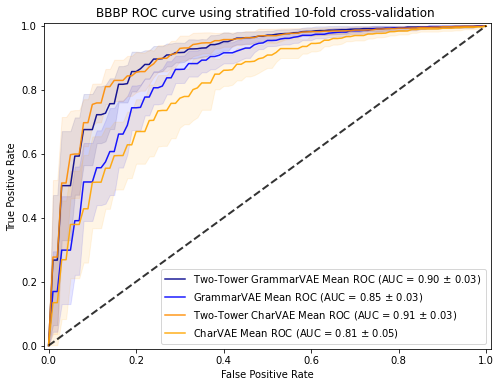

In [7]:
roc_curves=[]
roc_curves.append(get_average_ROC_curve(two_tower_grammar_latent_rep, grammar_targets, latent_rep_size=128))
roc_curves.append(get_average_ROC_curve(grammar_latent_rep, grammar_targets, latent_rep_size=128))

roc_curves.append(get_average_ROC_curve(two_tower_char_latent_rep, char_targets, latent_rep_size=128))
roc_curves.append(get_average_ROC_curve(char_latent_rep, char_targets, latent_rep_size=128))

plot_average_ROC_curves(roc_curves, "BBBP", ["Two-Tower GrammarVAE", "GrammarVAE", "Two-Tower CharVAE", "CharVAE"])

# **Multi-label Classification**

Run the following cells if the prediction task is a multi-label classification

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

def get_multilabel_ROC_score(X,y,latent_rep_size, output_size, folds=10):
    kfold = KFold(n_splits=folds, shuffle=True, random_state=0)
    aucs = []
    for train, test in tqdm(kfold.split(X, y), total=folds):
        model=create_model(input_size=latent_rep_size, output_size=output_size)
        model.fit(X[train], y[train], epochs=250, batch_size=256, validation_split=0.1, verbose=0, callbacks = [early_stop])
        preds=model.predict(X[test], batch_size=256)
       
        try:
            score=roc_auc_score(y[test], preds)
            aucs.append(score)
        except:
            continue
    print(np.average(aucs), np.std(aucs))


In [21]:
get_multilabel_ROC_score(two_tower_grammar_latent_rep, grammar_targets, latent_rep_size=128, output_size=2)
get_multilabel_ROC_score(grammar_latent_rep, grammar_targets, latent_rep_size=128, output_size=2)

get_multilabel_ROC_score(two_tower_char_latent_rep, char_targets, latent_rep_size=128, output_size=2)
get_multilabel_ROC_score(char_latent_rep, char_targets, latent_rep_size=128, output_size=2)

  0%|          | 0/10 [00:00<?, ?it/s]

0.7900417012059521 0.08328752155402591


  0%|          | 0/10 [00:00<?, ?it/s]

0.7357080921085275 0.08230621848774165


  0%|          | 0/10 [00:00<?, ?it/s]

0.7304171383114172 0.04738667221513073


100%|██████████| 10/10 [03:39<00:00, 21.92s/it]

0.6294108916371852 0.08103968420550661
